## LAB-10 - Fine-Tune VGG16 for Bird Classification
### Name: Harshitha Anishetty
### StudenID: 8903318

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand. 

This lab is the last one, so it is a bit more elaborated than the others. So make sure to take time to work through it.

A good starting point is to use the code in the notebook we went over in class - for fine-tuning VGG16. 

The goal of this lab is to achieve the best classification performance over three classes (species) of birds. This should be done by exploring data augmentation and fine-tuning of a pre-trained model (VGG16). Finally, explore and describe the results. 

If you are interested, you are encouraged to explore various training configurations, and see which one works better.

1. Obtain the Data
    1. Download the [BIRDS 525 SPECIES](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train) dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks. 
    2. Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`). 
    3. For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.
2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)
3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)
4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

##### Import libraries

In [6]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint


#### Obtain the Data

In [7]:
# Download and Unpack the Data

# Define paths for train, validation, and test data
data_dir = './data'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')


In [8]:
# Identify the 3 classes with the highest number of images
num_classes = 3
class_names = sorted([class_name for class_name in os.listdir(train_dir)])
class_counts = [len(os.listdir(os.path.join(train_dir, class_name)))
                for class_name in class_names]
selected_classes = np.argsort(class_counts)[-num_classes:]
selected_class_names = [class_names[idx] for idx in selected_classes]

# Use only the selected classes for the next steps
train_dir_selected = os.path.join(data_dir, "train_selected")
test_dir_selected = os.path.join(data_dir, "test_selected")
os.makedirs(train_dir_selected, exist_ok=True)
os.makedirs(test_dir_selected, exist_ok=True)

for class_name in selected_class_names:
    os.rename(os.path.join(train_dir, class_name),
              os.path.join(train_dir_selected, class_name))
    os.rename(os.path.join(test_dir, class_name),
              os.path.join(test_dir_selected, class_name))


#### Data Augmentation

In [9]:
# Data Augmentation

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir_selected,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = test_datagen.flow_from_directory(
    test_dir_selected,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


#### Fine-Tune VGG16

In [10]:
# Fine-Tune VGG16
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=[CategoricalAccuracy(), Precision(), Recall()])


# Define a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor='val_categorical_accuracy', mode='max')

epochs = 10
history = model.fit(train_generator, epochs=epochs,
                    validation_data=valid_generator, callbacks=[checkpoint])


Epoch 1/10


2023-08-06 18:35:41.792032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - ETA: 0s - loss: 0.8818 - categorical_accuracy: 0.6290 - precision: 0.7968 - recall: 0.3320

2023-08-06 18:39:19.366016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 222s 9s/step - loss: 0.8818 - categorical_accuracy: 0.6290 - precision: 0.7968 - recall: 0.3320 - val_loss: 0.4415 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 0.9333
Epoch 2/10
24/24 [==============================] - 211s 9s/step - loss: 0.5339 - categorical_accuracy: 0.8374 - precision: 0.9233 - recall: 0.7285 - val_loss: 0.2512 - val_categorical_accuracy: 0.9333 - val_precision: 0.9333 - val_recall: 0.9333
Epoch 3/10
24/24 [==============================] - 222s 9s/step - loss: 0.4290 - categorical_accuracy: 0.8696 - precision: 0.9024 - recall: 0.8199 - val_loss: 0.1257 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 0.9333
Epoch 4/10
24/24 [==============================] - 245s 10s/step - loss: 0.3583 - categorical_accuracy: 0.8844 - precision: 0.9092 - recall: 0.8347 - val_loss: 0.1056 - val_categorical_accuracy: 0.9333 - val_precision: 0.9333 - val_recall: 0.9333
Epoch 5/10
24/24 [====

#### Evaluate Model Performance

In [42]:
# Evaluate Model Performance
test_generator = test_datagen.flow_from_directory(
    test_dir_selected,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the best model checkpoint
best_model = tf.keras.models.load_model("best_model.h5")

# Evaluate the model
eval_metrics = best_model.evaluate(test_generator)

print("Evaluation Metrics:")
print(f"Loss: {eval_metrics[0]}")
print(f"Categorical Accuracy: {eval_metrics[1]}")
print(f"Precision: {eval_metrics[2]}")
print(f"Recall: {eval_metrics[3]}")

Found 15 images belonging to 3 classes.


2023-08-06 20:04:55.522371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 5s 5s/step - loss: 0.4415 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.9333
Evaluation Metrics:
Loss: 0.4414982497692108
Categorical Accuracy: 1.0
Precision: 1.0
Recall: 0.9333333373069763


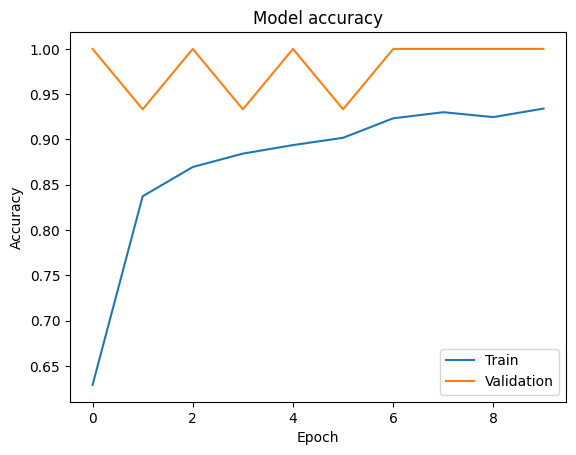

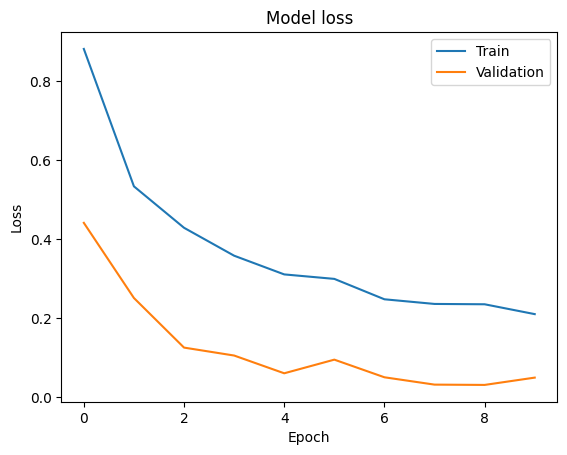

In [46]:

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



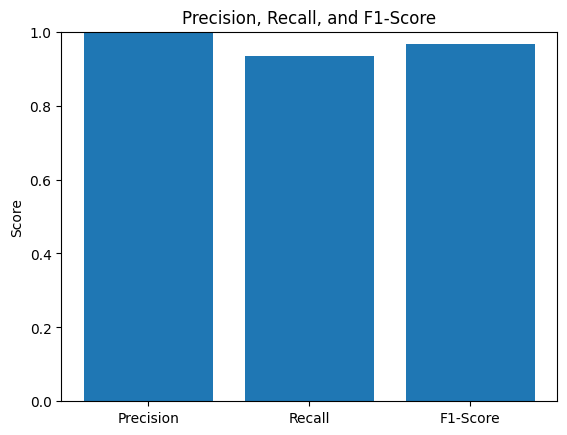

In [49]:
# Plot Precision, Recall, and F1-Score
precision = eval_metrics[2]
recall = eval_metrics[3]
f1_score = 2 * (precision * recall) / (precision + recall)

plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1_score])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score')
plt.show()


2023-08-06 20:05:17.012699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 5s 5s/step


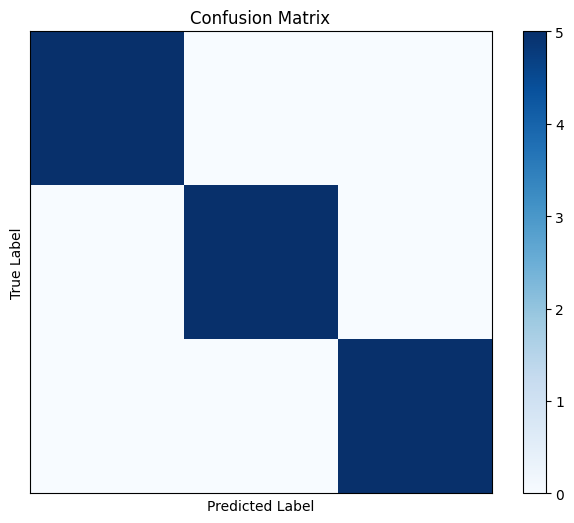

In [ ]:
# Confusion Matrix
test_generator.reset()
y_true = test_generator.classes
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, selected_class_names, rotation=45)
plt.yticks(tick_marks, selected_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
